In [320]:
import os, bz2, json, time
from datetime import timedelta
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

import statsmodels.api as sm
# from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from math import ceil, floor

import re

import time

import random

In [321]:
if not os.path.exists('active-dataset.p'):
    print('>>> Converting ACTIVE dataset from JSON format to pickle... might take a while!')
    active_videos = {}
    with bz2.BZ2File('active-dataset.json.bz2') as f:
        dataset = json.loads(f.readline())
    pickle.dump(dataset, open('active-dataset.p', 'wb'))
    
print('>>> Loading the ACTIVE dataset from pickle...')
active_videos = pickle.load(open('active-dataset.p', 'rb'))
df = pd.DataFrame(active_videos)

>>> Loading the ACTIVE dataset from pickle...


In [322]:
df.columns

Index(['YoutubeID', 'numTweet', 'numShare', 'numSubscriber', 'watchTime',
       'dailyViewcount', 'description', 'title', 'channelId', 'channelTitle',
       'category', 'uploadDate', 'duration', 'definition', 'dimension',
       'caption', 'regionRestriction.blocked', 'regionRestriction.allowed',
       'topicIds', 'relevantTopicIds', 'totalShare', 'totalViewcount',
       'totalTweet', 'dailyTweets'],
      dtype='object')

In [323]:
df.shape

(14041, 24)

In [324]:
df.head()

,YoutubeID,numTweet,numShare,numSubscriber,watchTime,dailyViewcount,description,title,channelId,channelTitle,...,dimension,caption,regionRestriction.blocked,regionRestriction.allowed,topicIds,relevantTopicIds,totalShare,totalViewcount,totalTweet,dailyTweets
0,00-6OyXVA0M,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[254, 1399, 493, 242, 175, 216, 372, 729, 305,...","[4, 19, 19, 7, 2, 5, 8, 17, 6, 3, 2, 1, 3, 1, ...","[59311.9833333, 455426.75, 206253.816667, 1119...","[90158, 695628, 312298, 170348, 82346, 61530, ...",Bill's response to Victoria Osteen's congregat...,Bill Cosby responds to Victoria Osteen,UCpzGw-b-rEPjRs2LT0ZVHTQ,Bryant Harris,...,2d,false,{},{},"[/m/03bxbhz, /m/03ny9x, /m/014zfs]",[/m/06bvp],5206,2174286,3857,"[2588, 455, 157, 100, 86, 76, 102, 64, 28, 23,..."
1,00ATf2HR-FA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[12, 47, 14, 32, 32, 12, 5, 4, 3, 4, 1, 0, 3, ...","[2, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2937.13333333, 9039.33333333, 5082.71666667, ...","[14939, 40664, 21261, 30914, 31073, 20395, 117...",Adorable Cute South Korean Dog Gets Neck Massa...,Adorable Cute South Korean Dog Gets Neck Massage,UCT7HvytJiHm4BITiIQU1zwg,CloudSheep,...,2d,false,{},{},"[/m/0b_nd, /m/0bt9lr]",[/m/04h3kx],201,227149,189,"[75, 25, 18, 18, 15, 5, 10, 2, 0, 1, 2, 0, 1, ..."
2,00bumpN0Mhw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[583, 316, 178, 107, 92, 84, 135, 122, 133, 90...","[250, 146, 94, 51, 55, 54, 79, 63, 66, 51, 35,...","[235606.866667, 177160.183333, 133966.883333, ...","[89627, 63829, 46999, 42951, 42902, 36271, 416...","Download ""The Pressure"" on iTunes: http://smar...",Jhené Aiko - The Pressure (Explicit),UCkiXOKnkDO4qz3njQoz86LA,JheneAikoVEVO,...,2d,false,[DE],{},"[/m/011rvmhv, /m/0nhwg69]","[/m/011ccd35, /m/04rlf]",5878,2868185,4533,"[507, 227, 119, 88, 68, 77, 89, 74, 59, 41, 41..."
3,00f0ct78HcU,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[38, 11, 4, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[386, 194, 59, 16, 12, 5, 4, 2, 9, 5, 8, 9, 8,...","[119054.283333, 68698.1166667, 34243.9166667, ...","[91431, 52484, 26459, 14774, 7700, 5314, 4872,...",DON'T WANT TO MISS A PRANK? Subscribe here! \n...,Tank Explosion Accident!,UCuAcfy-GKYd1SPj8iEtA3Zw,Dudesons,...,2d,false,{},{},[/m/04cb12],"[/m/0bqb0z, /m/014zdl, /m/07cmd]",73,444387,192,"[39, 20, 5, 3, 4, 1, 2, 1, 2, 3, 2, 1, 0, 2, 0..."
4,00g2ZbI3ung,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[18, 3, 1, 1, 5, 5, 3, 2, 1, 1, 1, 0, 2, 1, 0,...","[63, 20, 5, 15, 19, 16, 18, 17, 12, 8, 12, 15,...","[11655.7333333, 3733.05, 2094.01666667, 1368.9...","[15512, 5027, 2691, 1861, 2563, 3891, 2751, 22...",These miracles will make you a god damn sexual...,Dark Souls II: Don't use hexes PSA,UCwPnX0XSfxswF0rL78NzNIw,veselekov,...,2d,false,{},{},"[/m/0p8xwrr, /m/0dgs3gt]","[/m/06zm8z, /m/02dpv4]",123,237425,186,"[60, 3, 1, 0, 1, 2, 4, 2, 2, 2, 0, 0, 1, 1, 0,..."


In [325]:
df = df[['YoutubeID', 'watchTime', 'dailyViewcount', 'description', 
        'title', 'channelId', 'channelTitle', 'category', 'uploadDate', 
        'duration', 'definition', 'dimension', 'caption', 'regionRestriction.blocked', 
        'regionRestriction.allowed', 'topicIds', 'relevantTopicIds']]
df.head()

,YoutubeID,watchTime,dailyViewcount,description,title,channelId,channelTitle,category,uploadDate,duration,definition,dimension,caption,regionRestriction.blocked,regionRestriction.allowed,topicIds,relevantTopicIds
0,00-6OyXVA0M,"[59311.9833333, 455426.75, 206253.816667, 1119...","[90158, 695628, 312298, 170348, 82346, 61530, ...",Bill's response to Victoria Osteen's congregat...,Bill Cosby responds to Victoria Osteen,UCpzGw-b-rEPjRs2LT0ZVHTQ,Bryant Harris,Entertainment,2014-08-29 06:19:14,PT39S,sd,2d,false,{},{},"[/m/03bxbhz, /m/03ny9x, /m/014zfs]",[/m/06bvp]
1,00ATf2HR-FA,"[2937.13333333, 9039.33333333, 5082.71666667, ...","[14939, 40664, 21261, 30914, 31073, 20395, 117...",Adorable Cute South Korean Dog Gets Neck Massa...,Adorable Cute South Korean Dog Gets Neck Massage,UCT7HvytJiHm4BITiIQU1zwg,CloudSheep,Pets & Animals,2014-08-29 07:24:00,PT15S,sd,2d,false,{},{},"[/m/0b_nd, /m/0bt9lr]",[/m/04h3kx]
2,00bumpN0Mhw,"[235606.866667, 177160.183333, 133966.883333, ...","[89627, 63829, 46999, 42951, 42902, 36271, 416...","Download ""The Pressure"" on iTunes: http://smar...",Jhené Aiko - The Pressure (Explicit),UCkiXOKnkDO4qz3njQoz86LA,JheneAikoVEVO,Music,2014-09-03 02:00:05,PT4M22S,hd,2d,false,[DE],{},"[/m/011rvmhv, /m/0nhwg69]","[/m/011ccd35, /m/04rlf]"
3,00f0ct78HcU,"[119054.283333, 68698.1166667, 34243.9166667, ...","[91431, 52484, 26459, 14774, 7700, 5314, 4872,...",DON'T WANT TO MISS A PRANK? Subscribe here! \n...,Tank Explosion Accident!,UCuAcfy-GKYd1SPj8iEtA3Zw,Dudesons,Entertainment,2014-06-14 03:00:04,PT1M38S,sd,2d,false,{},{},[/m/04cb12],"[/m/0bqb0z, /m/014zdl, /m/07cmd]"
4,00g2ZbI3ung,"[11655.7333333, 3733.05, 2094.01666667, 1368.9...","[15512, 5027, 2691, 1861, 2563, 3891, 2751, 22...",These miracles will make you a god damn sexual...,Dark Souls II: Don't use hexes PSA,UCwPnX0XSfxswF0rL78NzNIw,veselekov,Film & Animation,2014-06-14 11:32:27,PT53S,hd,2d,false,{},{},"[/m/0p8xwrr, /m/0dgs3gt]","[/m/06zm8z, /m/02dpv4]"


Преобразуем в датасете последовательность просмотров в отдельные признаки

In [326]:
min_days = min(df['watchTime'].apply(lambda x: len(x)))
days = [f'day_{i}' for i in range(1, min_days + 1)]
timeline = pd.DataFrame(index=df['YoutubeID'], columns=days)

In [327]:
for i in tqdm(range(min_days)):
    timeline[f'day_{i + 1}'] = df['dailyViewcount'].str[i].values.astype('int64')

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 43.77it/s]


In [328]:
timeline.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_110,day_111,day_112,day_113,day_114,day_115,day_116,day_117,day_118,day_119
YoutubeID,,,,,,,,,,,,,,,,,,,,,
00-6OyXVA0M,90158,695628,312298,170348,82346,61530,76116,229360,109262,40695,...,493,452,452,423,1056,1407,1153,1081,664,576
00ATf2HR-FA,14939,40664,21261,30914,31073,20395,11713,7690,5526,6259,...,107,476,208,140,102,135,150,120,94,68
00bumpN0Mhw,89627,63829,46999,42951,42902,36271,41669,44901,37811,39228,...,14816,14153,14232,14372,12938,10972,11921,12811,12158,12724
00f0ct78HcU,91431,52484,26459,14774,7700,5314,4872,4604,4065,3843,...,512,578,601,842,1042,951,651,678,605,579
00g2ZbI3ung,15512,5027,2691,1861,2563,3891,2751,2234,2233,2034,...,540,667,693,836,874,937,983,1015,853,860


In [782]:
pred_val = 36
drops = [f'day_{i}' for i in range(pred_val, 120)]
y = timeline[drops[0]]
X = timeline.drop(columns=drops)

In [783]:
X.shape

(14041, 35)

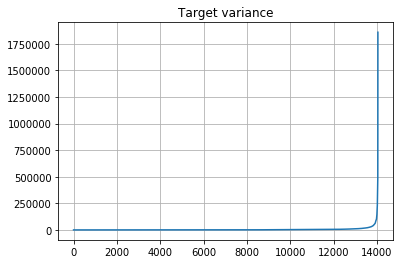

C:\Users\Александра\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


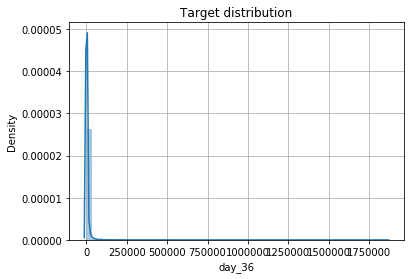

In [784]:
plt.title('Target variance')
plt.grid()
plt.plot(sorted(y))
plt.show()

plt.title('Target distribution')
sns.distplot(y)
plt.grid()
plt.show()

In [785]:
X['Month'] = pd.to_datetime(df[df.YoutubeID.isin(X.index)].uploadDate).dt.month.values
X['Day'] = pd.to_datetime(df[df.YoutubeID.isin(X.index)].uploadDate).dt.day.values
X['Hour'] = pd.to_datetime(df[df.YoutubeID.isin(X.index)].uploadDate).dt.hour.values
X['Weekday'] = pd.to_datetime(df[df.YoutubeID.isin(X.index)].uploadDate).dt.weekday.values

In [786]:
def format_duration(duration):
    """
    Format the duration of the video into seconds
    """
    sec_patrn = re.compile(r'(\d+)S')
    min_patrn = re.compile(r'(\d+)M')
    hr_patrn = re.compile(r'(\d+)H')

    seconds = sec_patrn.search(duration)
    minutes = min_patrn.search(duration)
    hours = hr_patrn.search(duration)

    seconds = int(seconds.group(1)) if seconds else 0
    minutes = int(minutes.group(1)) if minutes else 0
    hours = int(hours.group(1)) if hours else 0

    vid_seconds = timedelta(
        hours=hours,
        minutes=minutes,
        seconds=seconds
    ).total_seconds()

    return vid_seconds

X['duration'] = df[df.YoutubeID.isin(X.index)]['duration'].apply(format_duration).values

In [787]:
X['title'] = df[df.YoutubeID.isin(X.index)]['title'].values
X['description'] = df[df.YoutubeID.isin(X.index)]['description'].values
X['definition'] = df[df.YoutubeID.isin(X.index)]['definition'].values
X['definition'].fillna('Not stated', inplace=True)
X['category'] = df[df.YoutubeID.isin(X.index)]['category'].values
X['category'].fillna('Not stated', inplace=True)

In [788]:
X.loc[X['title'].str.upper() == X['title'], 'caps'] = 'Used'
X.loc[X['title'].str.upper() != X['title'], 'caps'] = 'Not used'

In [789]:
X.loc[(X['description'].str.find('http') != -1.0) &
        ~(X['description'].str.find('http').isna()), 'link'] = 'Used'
X.loc[(X['description'].str.find('http') == -1.0) |
        (X['description'].str.find('http').isna()), 'link'] = 'Not used'

In [790]:
X['min'] = X[X.columns[:pred_val - 1]].min(axis=1)
X['max'] = X[X.columns[:pred_val - 1]].max(axis=1)
X['mean'] = X[X.columns[:pred_val - 1]].mean(axis=1)

In [791]:
def approx(x : np.array, a : float, b : float, c : float) -> np.array:
    """
    Counts approximate trend line
    """
    return a / (np.exp(b * x) + c)


ids = []
parameters = {}
for row in tqdm(X.iterrows()):
    try:
        value = X.loc[row[0]][X.columns[:pred_val - 1]].values
        x_line = np.arange(0, pred_val - 1)
    #         plt.title(str(row[0]))
    #         plt.grid()
    #         plt.plot(value, label='val with trend')
        params, _ = curve_fit(approx, x_line, value, maxfev=100000)
        y_line = approx(x_line, *params)  
    #         plt.plot(y_line, label='trend')
        parameters[row[0]] = params
        X.loc[row[0], X.columns[:pred_val - 1]] = value - y_line
    #         plt.plot(value - y_line, label='val w\o trend')
    #         plt.legend()
    #         plt.show()
    except:
        ids.append(row[0])
        continue

0it [00:00, ?it/s]C:\Users\Александра\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
153it [00:14,  9.01it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
14041it [20:24, 11.47it/s]


In [792]:
len(ids)

191

In [793]:
X = X[~X.index.isin(ids)].fillna(0)
y = y[~y.index.isin(ids)].fillna(0).astype('float64')

In [794]:
for i in range(len(y)):
    y[i] -= approx(pred_val, *parameters[y.index[i]])

In [795]:
categorical = ['category', 'Month', 'Weekday', 'Hour', 'definition', 'link', 'caps']

numeric_features = ['min', 'max', 'mean', 'duration', *X.columns[:pred_val - 1].to_list()]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

In [699]:
check = pd.concat([X, y], axis=1)

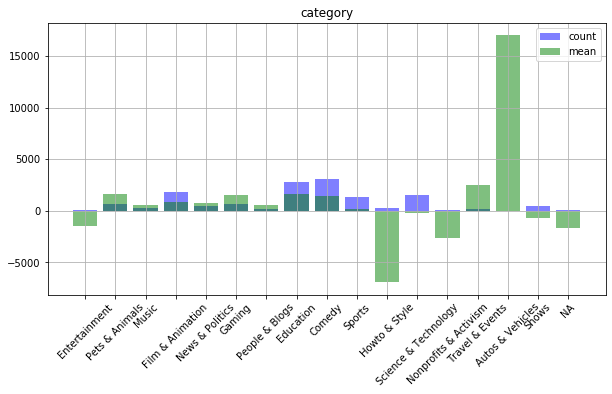

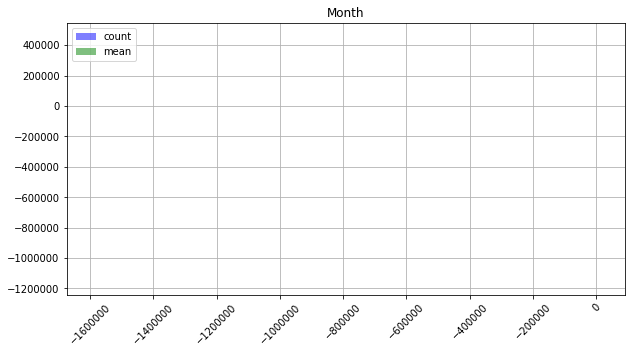

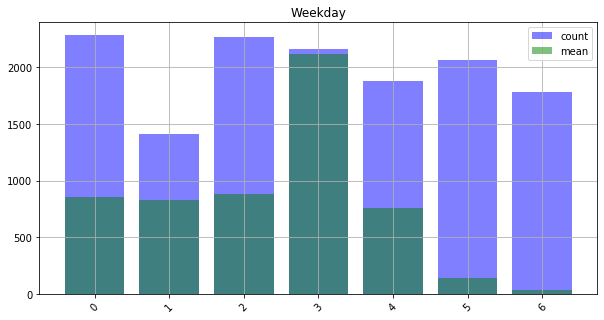

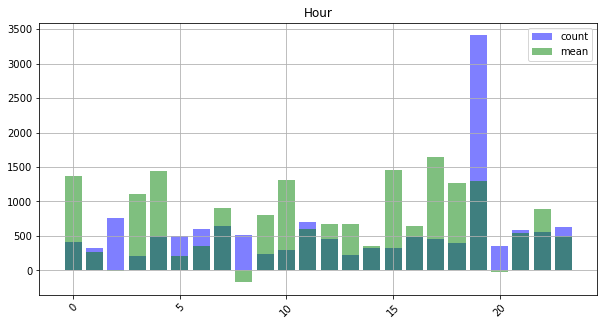

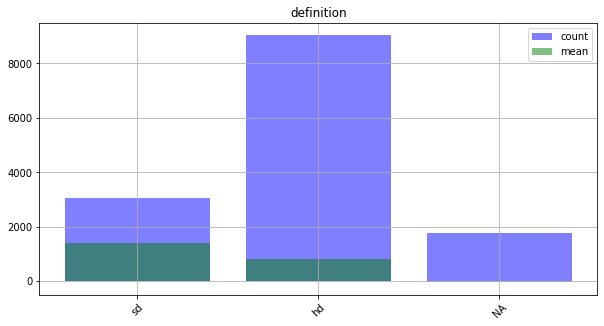

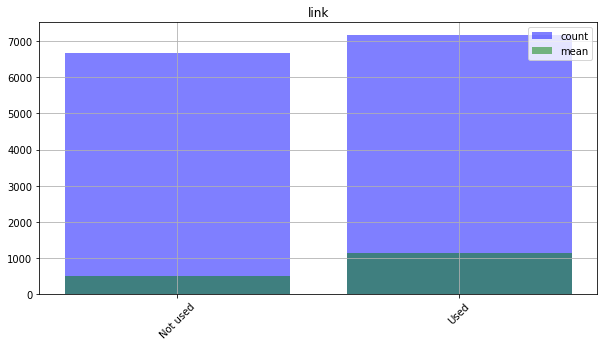

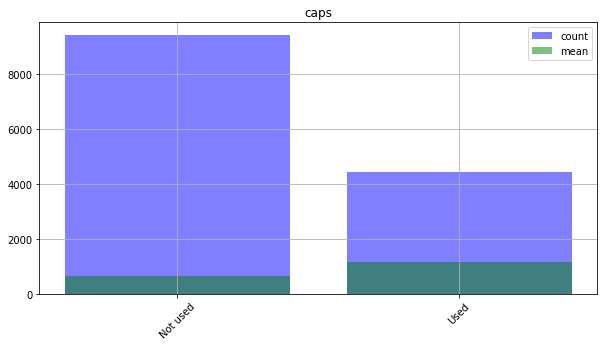

In [700]:
for cat in categorical:
    plt.figure(figsize=(10, 5))
    plt.title(cat)
    plt.grid()
    plt.bar(check[cat].unique(), check.groupby(cat).count()[f'day_{pred_val}'], alpha=0.5, color='blue', label='count')
    plt.bar(check[cat].unique(), check.groupby(cat).mean()[f'day_{pred_val}'], alpha=0.5, color='green', label='mean')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [587]:
ans = pd.DataFrame(index=['DecisionTree', 'Ridge', 'Lasso', 'GradientBoosting', 
                          'Bagging', 'CatBoost', 'HuberRegressor', 'TheilSenRegressor'], 
                   columns=['MSE', 'R2', 'Time'])

In [588]:
def get_models(X_valid, y_valid):
    models = []
    max_depth = [3, 5, 7]
    max_features = [int(np.sqrt(X_train.shape[1])), X_train.shape[1] // 2, X_train.shape[1] - 1]
    alpha = np.logspace(-3, 0, 8, dtype='float')
    n_estimators = [25, 50, 100]

    print('Searching DecisionTreeRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', DecisionTreeRegressor(random_state=21))]), 
                            [{"regression__max_depth": max_depth, "regression__max_features": max_features}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', DecisionTreeRegressor(random_state=21, 
                                                                 max_depth=searcher.best_params_["regression__max_depth"], 
                                                                 max_features=searcher.best_params_["regression__max_features"]))]))
    print('Finished!\n')

    print('Searching Ridge...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Ridge(random_state=21, solver='sag', max_iter=1000000))]), 
                            [{"regression__alpha" : alpha}], scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Ridge(random_state=21, solver='sag', max_iter=1000000, alpha=searcher.best_params_["regression__alpha"]))]))
    print('Finished!\n')

    print('Searching Lasso...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Lasso(random_state=21, max_iter=1000000))]), 
                            [{"regression__alpha" : np.logspace(-1, 0, 8, dtype='float')}], scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', Lasso(random_state=21, max_iter=10000000, 
                                                 alpha=searcher.best_params_["regression__alpha"]))]))
    print('Finished!\n')

    print('Searching GradientBoostingRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', GradientBoostingRegressor(max_features='sqrt', loss='huber', random_state=21))]), 
                            [{"regression__n_estimators": n_estimators, "regression__max_depth": max_depth, 
                              "regression__alpha": np.logspace(-4, -0.01, 8, dtype='float')}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', GradientBoostingRegressor(warm_start=False, 
                                                                     alpha=searcher.best_params_["regression__alpha"], 
                                                                     max_depth=searcher.best_params_["regression__max_depth"], 
                                                                     n_estimators=searcher.best_params_["regression__n_estimators"], 
                                                                     max_features='sqrt', random_state=21))]))
    print('Finished!\n')

    print('Searching BaggingRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', BaggingRegressor(random_state=21))]), 
                            [{"regression__n_estimators": n_estimators, "regression__max_features": max_features}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', BaggingRegressor(random_state=21, 
                                                            n_estimators=searcher.best_params_["regression__n_estimators"], 
                                                            max_features=searcher.best_params_["regression__max_features"]))]))
    print('Finished!\n')

    print('Searching CatBoostRegressor...')
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', CatBoostRegressor(loss_function='RMSE', random_seed=21, logging_level='Silent'))]))
    print('Finished!\n')

    print('Searching HuberRegressor...')
    searcher = GridSearchCV(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', HuberRegressor(max_iter=100000))]), 
                            [{"regression__alpha" : alpha}], scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid[[*numeric_features, *categorical]], y_valid)
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', HuberRegressor(max_iter=100000, alpha=searcher.best_params_["regression__alpha"]))]))
    print('Finished!\n')
    
    print('Searching TheilSenRegressor...')
    models.append(Pipeline(steps=[
                            ('ohe_and_scaling', column_transformer),
                            ('regression', TheilSenRegressor(random_state=21))]))
    print('Finished!\n')
    return models

In [589]:
def testing(model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):

    start = time.time()
    model.fit(X_train[[*numeric_features, *categorical]], y_train)
    fin = time.time() - start

    test = y_test.copy()
    y_pred = model.predict(X_test[[*numeric_features, *categorical]])
    
    for i in range(len(y_test)):
        val = approx(pred_val, *parameters[X_test.index[i]])
        test[i] += val
        y_pred[i] += val

    MSE = mean_squared_error(y_pred, test)
    R2 = r2_score(test, y_pred)

#     plt.figure(figsize=(30, 6))
#     plt.title(model)
#     plt.plot(y_pred, label='pred')
#     plt.plot(y_test, label='test')
#     plt.legend()
#     plt.show()

    return MSE, R2, fin, y_pred, test

In [555]:
batch = floor(X.shape[0] / 4)
print('Batch size:', batch)

data = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [dict(), dict(), dict(), dict(), dict()]))

for i in range(1, 5):
    print(f'\nBatch {i}')
    
    X_test = X[batch * (i - 1) : batch * i]
    y_test = y[X_test.index]
    X_valid = X.loc[np.random.choice(X.drop(index=X_test.index.tolist()).index, 
                                             batch, replace=False)]
    y_valid = y[X_valid.index]
    X_train = X.drop(index=[*X_test.index.to_list(), *X_valid.index.to_list()])
    y_train = y[X_train.index]
    
    models_set = get_models(X_valid, y_valid)
    
    for j, model in enumerate(models_set):
        curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(model, X_train, y_train, X_test, y_test)
        try:
            data['MSE'][ans.index.to_list()[j]].append(curr_MSE)
            data['R2'][ans.index.to_list()[j]].append(curr_R2)
            data['Time'][ans.index.to_list()[j]].append(curr_fin)
            data['Pred'][ans.index.to_list()[j]].extend(curr_pred)
            data['Act'][ans.index.to_list()[j]].extend(curr_test)
        except KeyError:
            data['MSE'][ans.index.to_list()[j]] = [curr_MSE]
            data['R2'][ans.index.to_list()[j]] = [curr_R2]
            data['Time'][ans.index.to_list()[j]] = [curr_fin]
            data['Pred'][ans.index.to_list()[j]] = curr_pred.tolist()
            data['Act'][ans.index.to_list()[j]] = curr_test.tolist()

Batch size: 3464

Batch 1
Searching DecisionTreeRegressor...
Finished!

Searching Ridge...
Finished!

Searching Lasso...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

Searching HuberRegressor...
Finished!

Searching TheilSenRegressor...
Finished!



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """



Batch 2
Searching DecisionTreeRegressor...
Finished!

Searching Ridge...
Finished!

Searching Lasso...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

Searching HuberRegressor...
Finished!

Searching TheilSenRegressor...
Finished!



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """



Batch 3
Searching DecisionTreeRegressor...
Finished!

Searching Ridge...
Finished!

Searching Lasso...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

Searching HuberRegressor...
Finished!

Searching TheilSenRegressor...
Finished!


Batch 4
Searching DecisionTreeRegressor...
Finished!

Searching Ridge...
Finished!

Searching Lasso...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

Searching HuberRegressor...
Finished!

Searching TheilSenRegressor...
Finished!



In [595]:
batch = floor(X.shape[0] / 4)
print('Batch size:', batch)
modelss = []

fin_m = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [[], [], [], [], []]))

for i in range(1, 5):
    print(f'\nBatch {i}')
    
    X_test = X[batch * (i - 1) : batch * i]
    y_test = y[X_test.index]
    X_valid = X.loc[np.random.choice(X.drop(index=X_test.index.tolist()).index, 
                                             batch, replace=False)]
    y_valid = y[X_valid.index]
    X_train = X.drop(index=[*X_test.index.to_list(), *X_valid.index.to_list()])
    y_train = y[X_train.index]
    
    models_set = Pipeline(steps=[('ohe_and_scaling', column_transformer),
                                 ('regression', TheilSenRegressor(random_state=21))])
    
    modelss.append(models_set)
    
    curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(models_set, X_train, y_train, X_test, y_test)
    try:
        fin_m['MSE'].append(curr_MSE)
        fin_m['R2'].append(curr_R2)
        fin_m['Time'].append(curr_fin)
        fin_m['Pred'].extend(curr_pred)
        fin_m['Act'].extend(curr_test)
    except KeyError:
        fin_m['MSE'] = [curr_MSE]
        fin_m['R2'] = [curr_R2]
        fin_m['Time'] = [curr_fin]
        fin_m['Pred'] = curr_pred.tolist()
        fin_m['Act'] = curr_test.tolist()

Batch size: 3468

Batch 1

Batch 2

Batch 3

Batch 4


In [649]:
weights = []
names = modelss[0][0].get_feature_names_out()

for m in modelss:
    weights.append(m[1].coef_)

In [650]:
weights = np.mean(weights, axis=0)

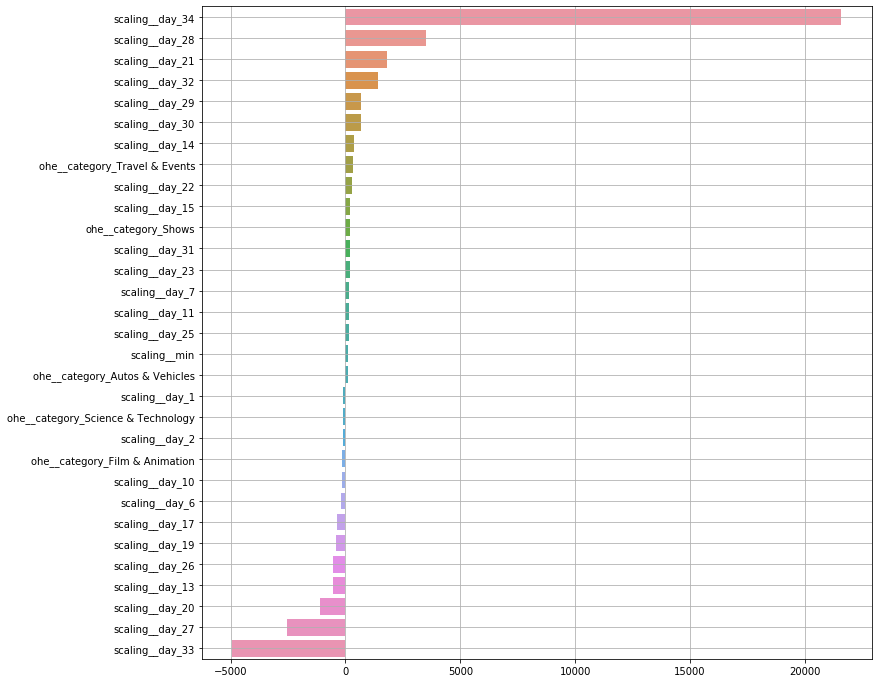

In [677]:
result = dict(zip(names, weights))
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: -item[1]) if abs(v) > 100}
pic = sns.barplot(y=list(sorted_result.keys()), x=list(sorted_result.values()))
pic.figure.set_size_inches(12, 12)
plt.grid()
plt.show()

Далее планирую реализовать смещение окна обучения, чтобы переиспользовать модель на последующие дни.

In [684]:
# pickle.dump(modelss[0], open('Model3', 'wb'))

In [814]:
loaded_model = pickle.load(open('Model3', 'rb'))

In [824]:
categorical = ['category', 'Month', 'Weekday', 'Hour', 'definition', 'link', 'caps']

numeric_features = ['min', 'max', 'mean', 'duration', *X.columns[1:pred_val - 1].to_list()]

In [825]:
X.columns = ['day_-1', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'day_32', 'day_33', 'Month',
       'Day', 'Hour', 'Weekday', 'duration', 'title', 'description',
       'definition', 'category', 'caps', 'link', 'min', 'max', 'mean']

In [821]:
# 36
t = time.time()
pred = loaded_model.predict(X)
fin = time.time() - t
print(m, '\n\tRMSE', mean_squared_error(y, pred, squared=False), 
      '\n\tR2', r2_score(y, pred),
      '\n\tTime', fin) 

Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['category', 'Month',
                                                   'Weekday', 'Hour',
                                                   'definition', 'link',
                                                   'caps']),
                                                 ('scaling', StandardScaler(),
                                                  ['min', 'max', 'mean',
                                                   'duration', 'day_1', 'day_2',
                                                   'day_3', 'day_4', 'day_5',
                                                   'day_6', 'day_7', 'day_8',
                                                   'day_9', 'day_10', 'day

### Result in prediction the 40th day

In [558]:
data_45 = data.copy()

In [556]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 19216.31228249319 
	R2 0.5163272999549791 
	Time 1.128746747970581
Ridge 
	RMSE 6520.44323860752 
	R2 0.9443114747601459 
	Time 26.325048446655273
Lasso 
	RMSE 7273.43757268923 
	R2 0.9307067532233253 
	Time 7.961267471313477
GradientBoosting 
	RMSE 18935.4511165461 
	R2 0.5303624735992941 
	Time 14.756948471069336
Bagging 
	RMSE 21938.4600205327 
	R2 0.3695890367016149 
	Time 194.0284481048584
CatBoost 
	RMSE 23593.35960962182 
	R2 0.2708933587779534 
	Time 69.75040459632874
HuberRegressor 
	RMSE 6026.998917360511 
	R2 0.9524211756635472 
	Time 47.86155962944031
TheilSenRegressor 
	RMSE 5745.542574301691 
	R2 0.956761205847718 
	Time 1065.4884374141693


In [557]:
best_preds = [data['Pred']['TheilSenRegressor'], data['Pred']['HuberRegressor'], 
              data['Pred']['Ridge'], data['Pred']['Lasso'], data['Pred']['GradientBoosting'], 
              data['Pred']['DecisionTree']]
i = 0
while i < 6:
    print(i)
    j = i
    curr_preds = []
    while j >= 0:
        curr_preds.append(best_preds[j])
        j -=1
    curr_pred = np.mean(curr_preds, axis=0)
    print('RMSE', mean_squared_error(curr_pred, data['Act'][ans.index.to_list()[j]], squared=False))
    print('R2', r2_score(data['Act'][ans.index.to_list()[j]], curr_pred))
    print()
    i += 1

0
RMSE 5745.542574301691
R2 0.956761205847718

1
RMSE 5850.325946532291
R2 0.9551697040509703

2
RMSE 5949.482799720312
R2 0.9536371733497956

3
RMSE 5964.423884453197
R2 0.9534040167020992

4
RMSE 6446.70121681402
R2 0.9455639549604218

5
RMSE 7835.49224448594
R2 0.9195837069111896



### Result in prediction the 35th day

In [512]:
data_35 = data.copy()

In [513]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 45217.39445832504 
	R2 -1.1228680647031877 
	Time 1.0189743041992188
Ridge 
	RMSE 19607.09232238121 
	R2 0.600847986678882 
	Time 34.8271381855011
Lasso 
	RMSE 17466.57654045918 
	R2 0.6832420531295462 
	Time 7.013058185577393
GradientBoosting 
	RMSE 29876.764321704202 
	R2 0.07321486555569046 
	Time 9.999874591827393
Bagging 
	RMSE 29579.88622015306 
	R2 0.09154183014088957 
	Time 102.28899717330933
CatBoost 
	RMSE 31749.726576628593 
	R2 -0.04662695585862808 
	Time 67.04512238502502
HuberRegressor 
	RMSE 16990.555552599304 
	R2 0.7002721518582025 
	Time 45.203229665756226
TheilSenRegressor 
	RMSE 16405.26963409824 
	R2 0.7205663637793284 
	Time 486.51721715927124


### Result in prediction the 28th day

In [490]:
data_28 = data.copy()

In [491]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 42151.302980888664 
	R2 -0.40685194659662227 
	Time 0.5509624481201172
Ridge 
	RMSE 27702.76712330423 
	R2 0.3923231523219054 
	Time 13.15146279335022
Lasso 
	RMSE 28968.972738427907 
	R2 0.3355036835807005 
	Time 4.232319355010986
GradientBoosting 
	RMSE 39603.62010342342 
	R2 -0.24192725895164546 
	Time 5.3455891609191895
Bagging 
	RMSE 41397.433387711855 
	R2 -0.35697929028648545 
	Time 25.088011741638184
CatBoost 
	RMSE 42951.82767869704 
	R2 -0.46079638294447434 
	Time 41.07464599609375
HuberRegressor 
	RMSE 29758.145536516997 
	R2 0.2988061238942271 
	Time 25.989314556121826
TheilSenRegressor 
	RMSE 27555.018174363006 
	R2 0.39878779109082496 
	Time 185.64625644683838


### Result in prediction the 22th day

In [466]:
data_22 = data.copy()

In [467]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 219988.84048681852 
	R2 -46.97611220207177 
	Time 0.8042891025543213
Ridge 
	RMSE 165024.7714956716 
	R2 -25.997405542860637 
	Time 21.52917981147766
Lasso 
	RMSE 177032.1304112648 
	R2 -30.069047683460788 
	Time 7.175753116607666
GradientBoosting 
	RMSE 175938.0567900598 
	R2 -29.68621560386573 
	Time 6.9862494468688965
Bagging 
	RMSE 158608.1104414428 
	R2 -23.938741447796684 
	Time 44.753650188446045
CatBoost 
	RMSE 154738.93598417894 
	R2 -22.736843294918902 
	Time 47.22268772125244
HuberRegressor 
	RMSE 150317.92530093872 
	R2 -21.399859596277608 
	Time 28.19179630279541
TheilSenRegressor 
	RMSE 149584.93627836937 
	R2 -21.18193721770392 
	Time 152.27956891059875


### Result in prediction the 15th day

In [443]:
data_15 = data.copy()

In [444]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 67057.51388849066 
	R2 -2.9945654516038416 
	Time 0.41370081901550293
Ridge 
	RMSE 48688.098938452764 
	R2 -1.1058153165210642 
	Time 8.961934328079224
Lasso 
	RMSE 48955.81620696035 
	R2 -1.1290371344167518 
	Time 4.211616277694702
GradientBoosting 
	RMSE 50925.31678641426 
	R2 -1.3037859408474723 
	Time 3.643986225128174
Bagging 
	RMSE 65787.86254798187 
	R2 -2.8447331108204974 
	Time 46.3728232383728
CatBoost 
	RMSE 69196.05516240057 
	R2 -3.2534106831191716 
	Time 39.745725870132446
HuberRegressor 
	RMSE 48949.058352716755 
	R2 -1.1284493909897755 
	Time 8.94518518447876
TheilSenRegressor 
	RMSE 48181.56876374886 
	R2 -1.062227232734505 
	Time 126.34619808197021


In [445]:
best_preds = [data['Pred']['TheilSenRegressor'], data['Pred']['Ridge'], 
              data['Pred']['HuberRegressor'], data['Pred']['GradientBoosting'], data['Pred']['Lasso'], 
              data['Pred']['DecisionTree']]
i = 0
while i < 6:
    print(i)
    j = i
    curr_preds = []
    while j >= 0:
        curr_preds.append(best_preds[j])
        j -=1
    curr_pred = np.mean(curr_preds, axis=0)
    print('RMSE', mean_squared_error(curr_pred, data['Act'][ans.index.to_list()[j]], squared=False))
    print('R2', r2_score(data['Act'][ans.index.to_list()[j]], curr_pred))
    print()
    i += 1

0
RMSE 48181.56876374886
R2 -1.062227232734505

1
RMSE 48264.5658960311
R2 -1.0693380997838426

2
RMSE 48337.193997903414
R2 -1.0755706297839702

3
RMSE 48509.39925880853
R2 -1.0903857577983964

4
RMSE 48509.05470135639
R2 -1.0903560622984014

5
RMSE 49304.051758662914
R2 -1.1594336587867722



### Result in prediction the 119th day

In [ ]:
data_119 = data.copy()

In [357]:
for m in ans.index.to_list():
    
    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
          '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
         '\n\tTime', np.sum(data['Time'][m])) 

DecisionTree 
	RMSE 10372.426997578259 
	R2 0.9069766183378969 
	Time 2.039752244949341
Ridge 
	RMSE 3114.600033288399 
	R2 0.991612434642174 
	Time 30.96923589706421
Lasso 
	RMSE 5769.248438543536 
	R2 0.9712213888010659 
	Time 16.235744953155518
GradientBoosting 
	RMSE 5720.416391532189 
	R2 0.9717065026125484 
	Time 14.103245973587036
Bagging 
	RMSE 12026.15088682966 
	R2 0.8749497263637522 
	Time 262.86948561668396
CatBoost 
	RMSE 15384.537937443132 
	R2 0.7953554120819496 
	Time 103.57903742790222
HuberRegressor 
	RMSE 3573.3055777811596 
	R2 0.9889599341435695 
	Time 52.179250955581665
TheilSenRegressor 
	RMSE 2613.196577401734 
	R2 0.9940956035435824 
	Time 3965.5662117004395


In [367]:
best_preds = [data['Pred']['TheilSenRegressor'], data['Pred']['Ridge'], 
              data['Pred']['HuberRegressor'], data['Pred']['GradientBoosting'], data['Pred']['Lasso'], 
              data['Pred']['DecisionTree']]
i = 0
while i < 6:
    print(i)
    j = i
    curr_preds = []
    while j >= 0:
        curr_preds.append(best_preds[j])
        j -=1
    curr_pred = np.mean(curr_preds, axis=0)
    print('RMSE', mean_squared_error(curr_pred, data['Act'][ans.index.to_list()[j]], squared=False))
    print('R2', r2_score(data['Act'][ans.index.to_list()[j]], curr_pred))
    print()
    i += 1

0
RMSE 2613.196577401734
R2 0.9940956035435824

1
RMSE 2611.6068472495226
R2 0.9941027852015301

2
RMSE 2838.2225786848185
R2 0.9930349498021536

3
RMSE 3150.256896791411
R2 0.9914192886746063

4
RMSE 3530.703687789744
R2 0.9892216100488443

5
RMSE 3711.6733234520225
R2 0.9880883797166738

